# Exploration

## Common

In [1]:
import os
import json
from pprint import pprint

In [2]:
%ls

Exploration of "all".ipynb  cmv/
Exploration.ipynb           rasa-x-helm.tgz


In [3]:
PAIR_TASK_HOLDOUT_PATH = "cmv/pair_task/heldout_pair_data.jsonlist"
PAIR_TASK_TRAIN_PATH = "cmv/pair_task/train_pair_data.jsonlist"

## Plan

### 1. Median length of threads


In [4]:
lines = open(PAIR_TASK_TRAIN_PATH).readlines()

In [5]:
lines = [json.loads(line) for line in lines]

In [6]:
print('Number of examples: {}'.format(len(lines)))
print('Number of examples with thread length 1: {}'.format(
    len([line for line in lines
    if len(line['positive']['comments']) == 1
    or len(line['negative']['comments']) == 1])
))

Number of examples: 3456
Number of examples with thread length 1: 3209


### Pick only those of length 1 for now

In [7]:
pos = [line for line in lines if len(line['positive']['comments']) == 1]
neg = [line for line in lines if len(line['negative']['comments']) == 1]
print("Relevant positive samples: {}".format(len(pos)))
print("Relevant negative sampels: {}".format(len(neg)))

Relevant positive samples: 2441
Relevant negative sampels: 2755


## 2. Quickly try out a supervised classifier

In [8]:
import numpy as np

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/amogh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import html
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text, remove_stop_words=False):
    text = ' '.join(text.splitlines())
    text = html.unescape(text)
    text = re.sub(r"[^a-zA-Z0-9\'\?!]+", ' ', text)
    text = re.sub(r"[0-9]+", "<NUM>", text)
    
    if remove_stop_words:
        text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [11]:
pos_text = [preprocess_text(thread['positive']['comments'][0]['body'], False) for thread in pos]
neg_text = [preprocess_text(thread['negative']['comments'][0]['body'], False) for thread in neg]

In [12]:
len(pos_text) + len(neg_text)

5196

In [13]:
all_text = pos_text + neg_text

In [14]:
lengths = [len(text) for text in all_text]
np.quantile(lengths, q=[0.9, 0.95])

array([2850.  , 3718.25])

In [15]:
max_features = 3000

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

Using TensorFlow backend.


In [99]:
tokenizer = Tokenizer(lower=True, num_words=max_features)
tokenizer.fit_on_texts(all_text)
X_train = tokenizer.texts_to_sequences(all_text)
y_train = np.array(([1] * len(pos_text)) + ([0] * len(neg_text)))
print("X: {}, Y: {}".format(len(X_train), len(y_train)))

X: 5196, Y: 5196


In [100]:
max_length = 120
X_train = np.array([i[:max_length] + [0] * max(0, max_length - len(i)) for i in X_train])

In [101]:
def get_data(path, tokenizer, max_length):
    lines = open(PAIR_TASK_TRAIN_PATH).readlines()
    lines = [json.loads(line) for line in lines]
    pos = [line for line in lines if len(line['positive']['comments']) == 1]
    neg = [line for line in lines if len(line['negative']['comments']) == 1]
    pos_text = [preprocess_text(thread['positive']['comments'][0]['body'], False) for thread in pos]
    neg_text = [preprocess_text(thread['negative']['comments'][0]['body'], False) for thread in neg]
    all_text = pos_text + neg_text
    X = tokenizer.texts_to_sequences(all_text)
    y = np.array(([1] * len(pos_text)) + ([0] * len(neg_text)))
    X = np.array([i[:max_length] + [0] * max(0, max_length - len(i)) for i in X])
    return X, y

In [102]:
def text_to_input(text):
    X = tokenizer.texts_to_sequences(text)
    X = np.array([i[:max_length] + [0] * max(0, max_length - len(i)) for i in X])
    return X

In [103]:
def input_to_text(input):
    text = tokenizer.sequences_to_texts(input)
    return text

In [104]:
X_train.shape

(5196, 120)

In [105]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [106]:
model = Sequential()
model.add(Embedding(max_features, 150))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [107]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [108]:
model.fit(X_train, y_train, batch_size=16, epochs=8, validation_data=get_data(PAIR_TASK_HOLDOUT_PATH, tokenizer, max_length))

/Users/amogh/.virtualenvs/discourse/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5196 samples, validate on 5196 samples
Epoch 1/8
5196/5196 [==============================] - 70s 13ms/step - loss: 0.6775 - accuracy: 0.5645 - val_loss: 0.6502 - val_accuracy: 0.6844
Epoch 2/8
5196/5196 [==============================] - 66s 13ms/step - loss: 0.6693 - accuracy: 0.6007 - val_loss: 0.6256 - val_accuracy: 0.6875
Epoch 3/8
5196/5196 [==============================] - 65s 12ms/step - loss: 0.6234 - accuracy: 0.6586 - val_loss: 0.5674 - val_accuracy: 0.7217
Epoch 4/8
5196/5196 [==============================] - 65s 12ms/step - loss: 0.5513 - accuracy: 0.7225 - val_loss: 0.4626 - val_accuracy: 0.7898
Epoch 5/8
5196/5196 [==============================] - 65s 12ms/step - loss: 0.4771 - accuracy: 0.7698 - val_loss: 0.3897 - val_accuracy: 0.8301
Epoch 6/8
5196/5196 [==============================] - 67s 13ms/step - loss: 0.4109 - accuracy: 0.8081 - val_loss: 0.3249 - val_accuracy: 0.8593
Epoch 7/8
5196/5196 [==============================] - 67s 13ms/step - loss: 0.354

### Calculate metrics

In [109]:
from sklearn.metrics import classification_report

X_test, y_test = get_data(PAIR_TASK_HOLDOUT_PATH, tokenizer, max_length)

y_pred = model.predict(X_test, batch_size=64, verbose=1)

5196/5196 [==============================] - 8s 2ms/step


(array([1228.,  258.,  139.,   68.,   62.,  142., 1316.,   24.,   26.,
          21.,   18.,   23.,   20.,   23.,   26.,   32.,   43.,   71.,
         146., 1510.]),
 array([2.36600637e-04, 5.02242632e-02, 1.00211926e-01, 1.50199592e-01,
        2.00187251e-01, 2.50174910e-01, 3.00162584e-01, 3.50150257e-01,
        4.00137901e-01, 4.50125575e-01, 5.00113249e-01, 5.50100923e-01,
        6.00088537e-01, 6.50076210e-01, 7.00063884e-01, 7.50051558e-01,
        8.00039232e-01, 8.50026906e-01, 9.00014520e-01, 9.50002193e-01,
        9.99989867e-01], dtype=float32),
 <a list of 20 Patch objects>)

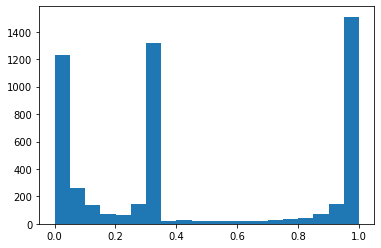

In [110]:
import matplotlib.pyplot as plt
plt.hist(y_pred, bins=20)

In [111]:
y_pred_train = model.predict(X_train, batch_size=64, verbose=1)

5196/5196 [==============================] - 9s 2ms/step


(array([1228.,  258.,  139.,   68.,   62.,  142., 1316.,   24.,   26.,
          21.,   18.,   23.,   20.,   23.,   26.,   32.,   43.,   71.,
         146., 1510.]),
 array([2.36600637e-04, 5.02242632e-02, 1.00211926e-01, 1.50199592e-01,
        2.00187251e-01, 2.50174910e-01, 3.00162584e-01, 3.50150257e-01,
        4.00137901e-01, 4.50125575e-01, 5.00113249e-01, 5.50100923e-01,
        6.00088537e-01, 6.50076210e-01, 7.00063884e-01, 7.50051558e-01,
        8.00039232e-01, 8.50026906e-01, 9.00014520e-01, 9.50002193e-01,
        9.99989867e-01], dtype=float32),
 <a list of 20 Patch objects>)

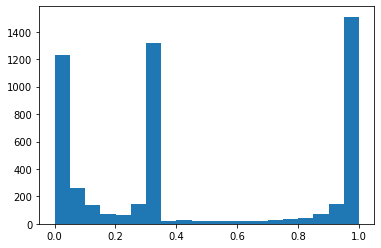

In [112]:
plt.hist(y_pred_train, bins=20)

In [113]:
y_pred_bool = [x > 0.5 for x in y_pred]
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      2755
           1       0.99      0.77      0.87      2441

    accuracy                           0.89      5196
   macro avg       0.91      0.88      0.89      5196
weighted avg       0.90      0.89      0.89      5196



In [114]:
sample_text = neg_text[-1]
sample_text

"Using your definition of free will just like infinite monkeys with infinite typewriters might only produce a long string of the letter A for eternity people could produce an infinitely long strong of non sin actions for eternity Who is to say the extremely improbable approaching zero probability this occurs for every being in heaven is not possibly going to be the case? It'd be pretty ridiculous but yet still actually possible Infinity and probability are strange things and perhaps this insanely unlikely outcome occurs for every person who makes it into heaven it could theoretically happen and there would be no issue with free will being violated here <NUM> is certainly not true even if the only condition needed for sin to occur is the individual ability to choose it's just very likely to be the case With that said I would suggest it's entirely possible to have free will and yet be incapable of choosing to sin Free will is about having a free choice and you can have a free choice betw

In [115]:
text_to_input([sample_text])

array([[ 308,   27,  583,    4,  262,   49,   42,   44, 2333,   21, 2333,
         140,   69, 1202,    3,  188,    4,    1,    3,   13,   22,   91,
        1202,   37,  188,  618,    4,  293, 2548,  511,   13,   46,    7,
           2,   94,    1,  564, 1195, 2885,   25, 2372,   13,  143,   70,
           9, 2495,    7,   16,  976,  102,    2,   15,    1,  225,   15,
         223, 1785,   19,  442,  119,  134,  278,    5, 2885,   12, 2853,
          81,    5,  542,   25, 1500, 1597, 2372,   13,  143,  100,   46,
         163,   10,  103, 2495,   10,   91,  369,    5,   38,   29,   15,
          58,  255,   21,  262,   49,   70,  160,   14,    7,  422,   16,
         233,   64,   23,    1,   69, 1525,  854,   13, 2548,    2, 1848,
           7,    1,  434,  471,    2,  510,   39,   42,   92,  220]])

In [116]:
model.predict_proba(text_to_input([sample_text]))

array([[0.00564289]], dtype=float32)

In [117]:
sample_text = """Here's the difference Something happens to Mary Mary gets mugged You response is Well why was she walking through that street at night? That's stupid she should have known she would get mugged The correct response is Well that's unfortunate That's a really unsafe area The news the police the community should do more to ensure peoples awareness and safety in that area Do you see the difference? One is victim blaming The other is having a mature discussion regarding the crime It begins a helpful discussion on the realities of the situation and ways to improve the situation It acknowledges your point that there are dangers in the world that people can work to avoid without dismissing the actual crime down to the victim's decisions The first just says it's all Mary's fault It's a massive difference The first one should never be discussed outside of the victim the police and family What if Mary was from out of town and didn't know the area was unsafe? What if Mary got lost? What if Mary got in a fight with her boyfriend and was kicked out of the car there? Are all of these not perfectly understandable reasons why Mary would be at that specific location at that time of night? How are you in any specific way able to judge the situation and draw those particular conclusions? Does the second response not completely cover both your requirements? Explaining the causation of the crime and helping people through doing so worthwhile ? Does it not do both of those in a better way ? It's assumed that the first response does accomplishes these goals but in fact it doesn't It's a psychological knee jerk response You hit the nail on the head here you just miss the connection between the two The world is not a just place but people want it to be and subconsciously try to make it feel that way By saying things like she shouldn't have been there we are exactly saying This would never happen to me because I would never do that and therefore make yourself feel better by justifying the issue and therefore the world When we do that we dismiss the actual problem We don't talk about the safety of the street and how to improve it we don't talk about mental illness improvements and education and lowering poverty so we make the world a better place We talk about Mary And how stupid she was EDIT Things got confusing here I think so I want to clarify a couple things <NUM> The point of all these examples was this Causation can be discussed with or without victim blaming and doing it with victim blaming does no one any good These discussions typically do include victim blaming because it's human nature to victim blame and discussing the topic without victim blaming is actually challenging <NUM> How does this relate to OP's topic Discussing causation is completely unrelated to victims at all If you are discussing a specific victim you're probably victim blaming and this is what tends to happen the most If you're discussing the situation that happened you're discussing causation <NUM> I am not suggesting people not take personal responsibility for their safety It all falls down to the reasonableness of actions that we require from others It's perfectly reasonable to require someone to lock their door It's not reasonable to expect them to completely board up their house <NUM> I wasn't trying to ignite a discussion on when we should or should not victim blame or where lines of personality responsibility are drawn and I don't feel like that thread is relevant to the topic I was discussing only the conversation that occurs after there has been a crime"""

In [118]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [119]:
def predict_proba(text):
    X = text_to_input(text)
    probs = [x[0] for x in model.predict_proba(X)]
    return np.array([np.array([1 - prob, prob]) for prob in probs])

In [120]:
explainer = LimeTextExplainer(class_names=['non_persuasive', 'persuasive'])

In [121]:
exp = explainer.explain_instance(sample_text, predict_proba)

In [122]:
exp.show_in_notebook()

## 3. Find statistics of 3 clusters

In [123]:
from sklearn.cluster import KMeans

In [133]:
n_clusters = 2

In [134]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_test)

In [135]:
kmeans.labels_

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

In [136]:
clusters_test = [X_test[np.where(kmeans.labels_ == i)] for i in range(n_clusters)]

In [137]:
clusters_test_pred = [model.predict(cluster, batch_size=64) for cluster in clusters_test]

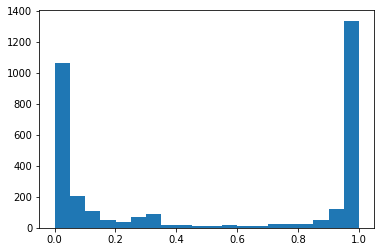

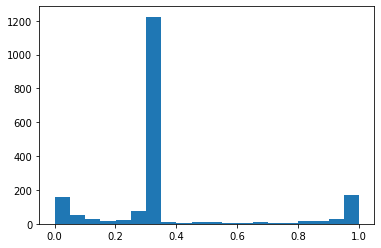

In [138]:
for i in range(n_clusters):
    plt.hist(clusters_test_pred[i], bins=20)
    plt.show()

In [140]:
input_to_text(clusters_test[1])

['look at the definition you provided if we remove the of things which humans create existing in nature and not made or caused by people so essentially by this definition natural things are things that exist which is frankly rather meaningless if one wanted to discuss the results of human activity we would then have to make up a new word which could be by the same argument the whole point of the word is to human activity if you remove that aspect it simply to have meaning',
 'this answer in r does a pretty good job of essential http www reddit com r comments num num r how effective are essential as the comment points out there are benefits to essential if they are used in the right way however the current the essential with other stuff that may or may not be good for you the essential are actually a resource for drug',
 "it looks to me like you've made so many exceptions to your main view that you aren't looking to have your view changed i'd like to talk about the title of your post bu

In [154]:
texts = input_to_text(clusters_test[0])
np.quantile(list(map(lambda x: len(x.split()), texts)), [0.1, 0.5, 0.9])

array([120., 120., 120.])

In [153]:
texts = input_to_text(clusters_test[1])
np.quantile(list(map(lambda x: len(x.split()), texts)), [0.25, 0.5, 0.9])

array([ 69.,  89., 120.])

In [158]:
np.quantile(list(map(lambda x: len(x.split()), pos_text)), [0.25, 0.5, 0.75])

array([143., 234., 382.])

In [159]:
np.quantile(list(map(lambda x: len(x.split()), neg_text)), [0.25, 0.5, 0.75])

array([103.5, 161. , 266. ])